In [7]:
import pyproj
import rasterio
import numpy as np
from shapely.geometry import Polygon, Point
from rasterio.windows import from_bounds
from rasterio.windows import transform as window_transform
import psycopg2
from psycopg2.extras import DictCursor
import boto3
import os
import psycopg2
from datetime import datetime, timedelta
import json
import shutil

In [8]:
def lonlat_to_utm(lon, lat, zone_number):
    """Convert longitude and latitude to UTM coordinates."""
    wgs84_proj = pyproj.CRS("EPSG:4326")  # WGS84 (longitude, latitude)
    utm_proj = pyproj.CRS(f"EPSG:326{zone_number}")  # UTM Zone 30T

    transformer = pyproj.Transformer.from_crs(wgs84_proj, utm_proj, always_xy=True)
    return transformer.transform(lon, lat)

def convert_polygon_to_utm(polygon, zone_number):
    """Convert a list of polygon points from lon/lat to UTM (meters)."""
    return [lonlat_to_utm(lon, lat, zone_number) for lon, lat in polygon]

def get_points_in_polygon(polygon, x_vals, y_vals, ndwi_values, ndvi_values, savi_values, evi_values):
    """Get the values of grid points inside the polygon."""
    polygon_shape = Polygon(polygon)
    ndwi_list = []
    ndvi_list = []
    savi_list = []
    evi_list = []
    # Generate a 2D grid of coordinates
    grid_x, grid_y = np.meshgrid(x_vals, y_vals)
    grid_x_flat = grid_x.flatten()
    grid_y_flat = grid_y.flatten()

    # Ensure values are flattened to match the grid
    ndwi_values_flat = ndwi_values.flatten()
    ndvi_values_flat = ndvi_values.flatten()
    savi_values_flat = savi_values.flatten()
    evi_values_flat = evi_values.flatten()
    
    for x, y, ndwi_val, ndvi_val, savi_val, evi_val in zip(grid_x_flat, grid_y_flat, ndwi_values_flat, ndvi_values_flat, savi_values_flat, evi_values_flat):
        point = Point(x, y)
        if polygon_shape.contains(point):
            ndwi_list.append(ndwi_val)
            ndvi_list.append(ndvi_val)
            savi_list.append(savi_val)
            evi_list.append(evi_val)
        
    return ndwi_list, ndvi_list, savi_list, evi_list

In [33]:
def calculate_average_indicators_for_polygon(polygon, tci_image_path, nir_image_path, zone_number):
    """Calculate average NDWI, NDVI, SAVI, and EVI for the given polygon."""
    
    # Open the TCI image and NIR image
    with rasterio.open(tci_image_path) as src_tci, rasterio.open(nir_image_path) as src_nir:

        # Convert polygon to UTM and calculate the bounding box
        polygon_utm = convert_polygon_to_utm(polygon, zone_number)
        all_x = [coord[0] for coord in polygon_utm]
        all_y = [coord[1] for coord in polygon_utm]
        min_x, max_x = min(all_x), max(all_x)
        min_y, max_y = min(all_y), max(all_y)

        # Read a subset of the image using the bounding box
        polygon_window = from_bounds(min_x, min_y, max_x, max_y, src_tci.transform)
        subset_rgb_image = src_tci.read([1, 2, 3], window=polygon_window)
        subset_nir_image = src_nir.read(1, window=polygon_window)  # Read NIR band for subset
        subset_ndwi_image = (subset_rgb_image[1, :, :] - subset_nir_image) / (subset_rgb_image[1, :, :] + subset_nir_image)
        subset_ndvi_image = (subset_nir_image - subset_rgb_image[0, :, :]) / (subset_nir_image + subset_rgb_image[0, :, :])
        
        # Calculate SAVI (Soil-Adjusted Vegetation Index)
        savi_image = (subset_nir_image - subset_rgb_image[0, :, :]) / (subset_nir_image + subset_rgb_image[0, :, :] + 0.5)  # Using L=0.5
        
        # Calculate EVI (Enhanced Vegetation Index)
        evi_image = 2.5 * (subset_nir_image - subset_rgb_image[0, :, :]) / (subset_nir_image + 6 * subset_rgb_image[1, :, :] - 7.5 * subset_rgb_image[2, :, :] + 1)
        
        # Get the transform for the subset
        subset_transform = window_transform(polygon_window, src_tci.transform)


    return subset_rgb_image, subset_nir_image, subset_ndwi_image, subset_ndvi_image, savi_image, evi_image
    

In [44]:
tci_path = "C://Users//Javier//Desktop//CROP//Sentinel2_trial//2024//3//1//TCI.jp2"
nir_path = "C://Users//Javier//Desktop//CROP//Sentinel2_trial//2024//3//1//B08.jp2"
zone_number = 30

polygon = "[[-5.658595234, 40.113459305], [-5.658060823, 40.113190705], [-5.658071313, 40.1135192], [-5.657992994, 40.113597684], [-5.657766142, 40.113705082], [-5.657444767, 40.114145001], [-5.657520385, 40.114277182], [-5.65819014, 40.114518826], [-5.65870596, 40.114027276], [-5.658678954, 40.113630729], [-5.658595234, 40.113459305]]"
polygon = json.loads(polygon)
subset_tci_image, subset_nir_image, subset_ndwi_image, subset_ndvi_image, savi_image, evi_image = calculate_average_indicators_for_polygon(polygon, tci_path, nir_path, zone_number)



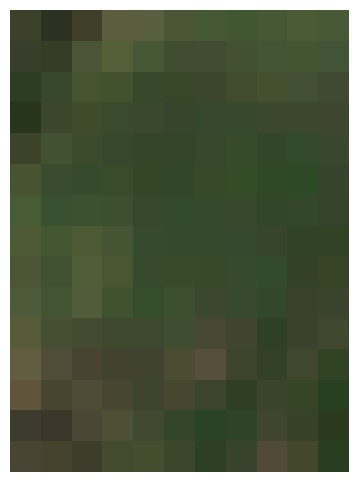

In [43]:
import matplotlib.pyplot as plt
import numpy as np

def plot_rgb_image(rgb_image):
    """
    Plot a 6x6 RGB image.
    """
    # Convert from (3, H, W) to (H, W, 3) for Matplotlib
    rgb_image = np.moveaxis(rgb_image, 0, -1)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(rgb_image)  # Normalize RGB values to [0, 1]
    plt.axis('off')
    plt.show()

# Call the function to plot the RGB image
plot_rgb_image(subset_tci_image)


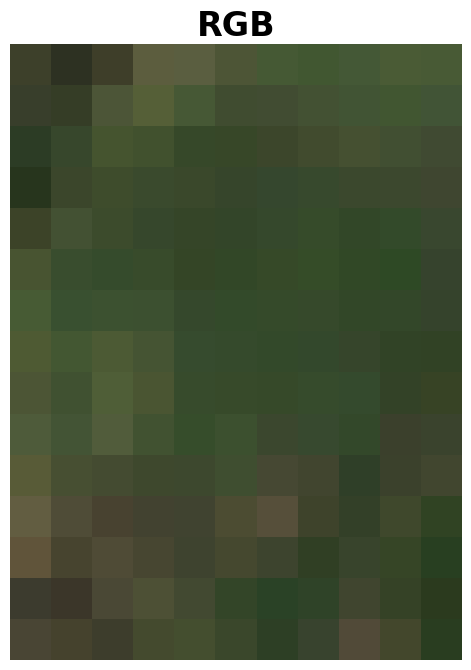

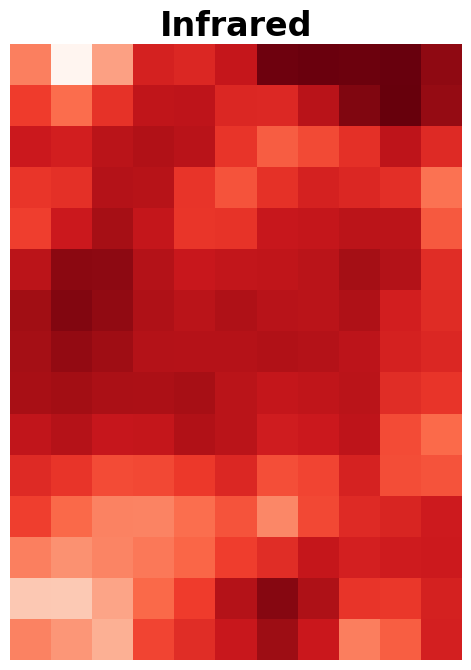

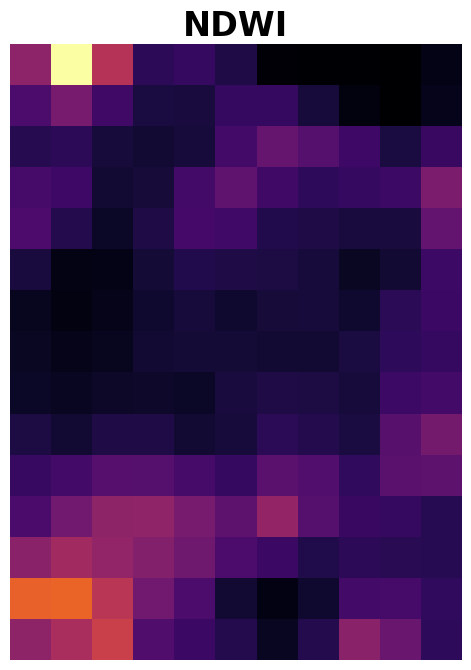

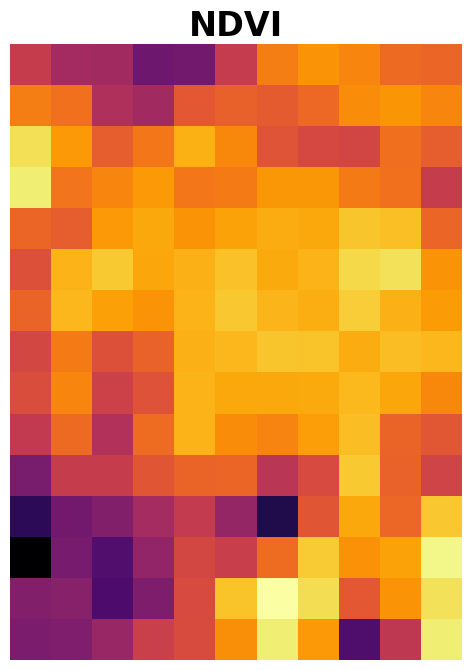

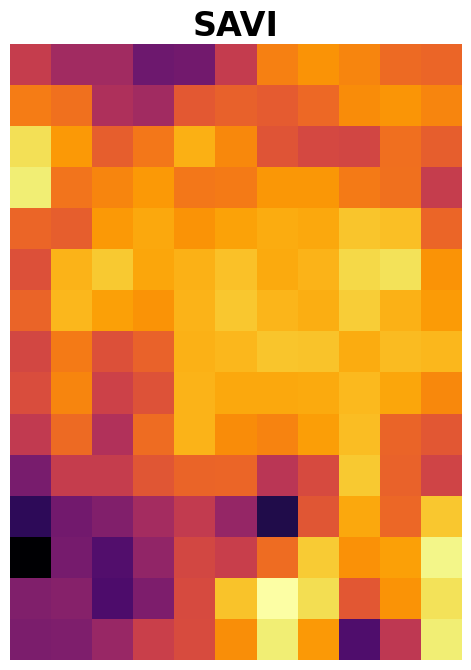

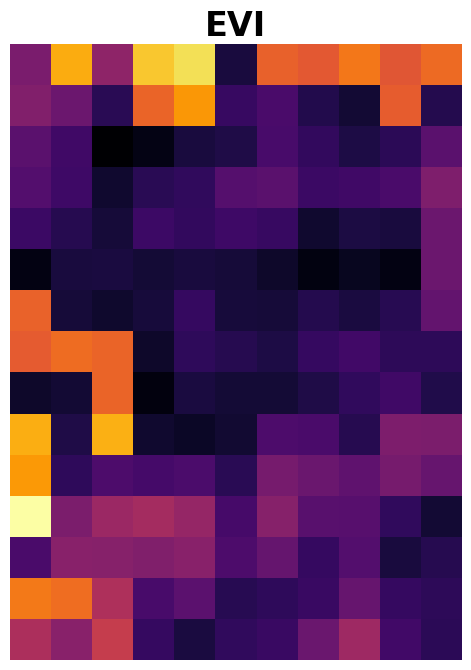

In [53]:
import matplotlib.pyplot as plt
import numpy as np

def plot_image(image, title, cmap=None):
    """
    Utility function to plot an image in a separate figure.
    """
    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap=cmap)
    plt.title(title, fontsize=24, fontweight='bold')
    plt.axis('off')
    plt.show()

# Assuming subset_tci_image, subset_nir_image, subset_ndwi_image, subset_ndvi_image, savi_image, and evi_image are already computed
def plot_images_separately(subset_tci_image, subset_nir_image, subset_ndwi_image, subset_ndvi_image, savi_image, evi_image):
    """
    Plot the subset images: TCI, NIR, NDWI, NDVI, SAVI, and EVI separately.
    """
    # Plot True Color Image (RGB)
    rgb_image = np.moveaxis(subset_tci_image, 0, -1)  # Convert from (3, H, W) to (H, W, 3)
    plot_image(rgb_image / 255.0, "RGB")

    # Plot NIR Image
    plot_image(subset_nir_image, "Infrared", cmap='Reds')

    # Plot NDWI
    plot_image(subset_ndwi_image, "NDWI", cmap='inferno')

    # Plot NDVI
    plot_image(subset_ndvi_image, "NDVI", cmap='inferno')

    # Plot SAVI
    plot_image(savi_image, "SAVI", cmap='inferno')

    # Plot EVI
    plot_image(evi_image, "EVI", cmap='inferno')

# Call the function to plot the images
plot_images_separately(subset_tci_image, subset_nir_image, subset_ndwi_image, subset_ndvi_image, savi_image, evi_image)
